<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />

# A ver si nos hacemos ricos<a id="top"></a>

<i><small>Last update: 2023-04-09</small></i></div>
***

## Introducción

Vamos a explorar el comportamiento de una red recurrente en el problema de predicción bursátil. Se trata de un problema muy difícil de resolver por varias razones.

En primer lugar, el mercado de valores es un sistema **altamente complejo** y dinámico, en el que multitud de factores pueden influir en los precios de las acciones. Estos factores incluyen las condiciones económicas mundiales, los acontecimientos políticos, los resultados de las empresas y el sentimiento de los inversores, entre otros. Por lo tanto, es difícil captar y modelizar todas estas complejas relaciones utilizando una única arquitectura RNN.

En segundo lugar, el mercado de valores se caracteriza por **patrones no estacionarios y no lineales**, en los que las relaciones entre entradas y salidas pueden cambiar con el tiempo. Las RNN son particularmente adecuadas para modelizar datos de series temporales, pero pueden tener dificultades para captar patrones no lineales y no estacionarios, especialmente en horizontes temporales largos.

En tercer lugar, el mercado bursátil **está sujeto a acontecimientos impredecibles** que pueden tener un impacto significativo en los precios de las acciones. Por ejemplo, las noticias inesperadas o los cambios repentinos en la confianza del mercado pueden provocar cambios importantes y rápidos en los precios de las acciones que pueden ser difíciles de predecir utilizando únicamente datos históricos.

Por último, el mercado bursátil es un entorno altamente competitivo, en el que inversores y operadores utilizan diversas técnicas sofisticadas para obtener una ventaja en el mercado. Esto significa que cualquier modelo de predicción debe ser capaz de superar al mercado para ser útil, lo cual es una tarea difícil.

## Objetivos

Crearemos un modelo de regresión para intentar predecir el valor de cierre que tendrán las acciones de Google (<https://es.finance.yahoo.com/quote/goog/>).

## Bibliotecas y configuración

A continuación importaremos las bibliotecas que se utilizarán a lo largo del cuaderno.

In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

2023-05-16 19:02:02.932065: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 19:02:03.069548: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-16 19:02:03.069565: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-16 19:02:03.958968: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

También configuraremos algunos parámetros para adaptar la presentación gráfica.

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (20, 6),'figure.dpi': 64})

***

## Descarga y preprocesamiento de datos

Empezaremos cargando los datos del conjunto de datos de acciones de Google. Para ello tomaremos los datos históricos de la empresa de los últimos 5 años.

In [3]:
CODE = 'GOOG'
BASE_URL = f'https://query1.finance.yahoo.com/v7/finance/download/{CODE}'
# Interval
today = datetime.datetime.now()
five_years_ago = today - datetime.timedelta(days=365*5)
# Timestamps (as integer) for the interval
period2 = int(today.timestamp())
period1 = int(five_years_ago.timestamp())
# Now get the dataframe
df = pd.read_csv(
    f'{BASE_URL}?period1={period1}&period2={period2}&interval=1d',
    index_col='Date',
    parse_dates=['Date'],
    dtype=np.float32
)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-05-17,53.994499,54.343498,53.674999,53.929501,53.929501,20876000.0
2018-05-18,53.092999,53.497002,53.034000,53.318001,53.318001,31304000.0
2018-05-21,53.702999,54.400002,53.682499,53.979000,53.979000,20464000.0
2018-05-22,54.178001,54.329498,53.334499,53.486500,53.486500,21800000.0
2018-05-23,53.256500,54.039001,53.085499,53.984501,53.984501,21214000.0


El conjunto de datos que hemos descargado guarda la información del día. Nuestro objetivo será predecir el valor de cierre del día a partir de los datos de la semana pasada, para saber qué tipo de inversión nos conviene.

Alimentaremos la red con datos de hace 10 días para ver si la memoria sobre cómo evolucionan los valores se traduce en una mejor predicción. Para ello, empezaremos creando 95 nuevas columnas con el contenido de las columnas en cada paso temporal consecutivo.

Nótese que primero debemos ordenar el conjunto en orden ascendente para asegurarnos de que tenemos los días correctamente colocados. En segundo lugar, la primera

In [4]:
SEQUENCE_LEN = 10

df.sort_index(inplace=True)
columns = df.columns
for i in range(1, SEQUENCE_LEN):
    for column in columns:
        df[f'{column} t-{i}'] = df[column].shift(i)
df.drop(df.head(SEQUENCE_LEN - 1).index, inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Open t-1,High t-1,Low t-1,Close t-1,...,Low t-8,Close t-8,Adj Close t-8,Volume t-8,Open t-9,High t-9,Low t-9,Close t-9,Adj Close t-9,Volume t-9
Date,,,,,,,,,,,,,,,,,,,,,
2018-05-31,53.377998,54.859501,53.377998,54.249500,54.249500,61766000.0,53.151501,53.460499,52.841499,53.389999,...,53.034000,53.318001,53.318001,31304000.0,53.994499,54.343498,53.674999,53.929501,53.929501,20876000.0
2018-06-01,54.967499,56.000000,54.924999,55.974998,55.974998,48432000.0,53.377998,54.859501,53.377998,54.249500,...,53.682499,53.979000,53.979000,20464000.0,53.092999,53.497002,53.034000,53.318001,53.318001,31304000.0
2018-06-04,56.116501,57.094501,56.100250,56.964500,56.964500,37792000.0,54.967499,56.000000,54.924999,55.974998,...,53.334499,53.486500,53.486500,21800000.0,53.702999,54.400002,53.682499,53.979000,53.979000,20464000.0
2018-06-05,57.049500,57.286900,56.659500,56.983002,56.983002,33560000.0,56.116501,57.094501,56.100250,56.964500,...,53.085499,53.984501,53.984501,21214000.0,54.178001,54.329498,53.334499,53.486500,53.486500,21800000.0
2018-06-06,57.108501,57.150002,56.287151,56.844002,56.844002,33964000.0,57.049500,57.286900,56.659500,56.983002,...,53.307499,53.962002,53.962002,15336000.0,53.256500,54.039001,53.085499,53.984501,53.984501,21214000.0


Continuaremos creando una nueva columna llamada `Y` con los valores de la columna `Close/Last` de una semana más tarde. Al igual que antes, las últimas 7 filas del conjunto de datos no nos servirán de nada, ya que no podemos ver el futuro, por lo que las eliminaremos.

In [5]:
DAYS_IN_FUTURE = 7

df['Y'] = df['Close'].shift(-DAYS_IN_FUTURE)
df.drop(df.tail(DAYS_IN_FUTURE).index, inplace=True)

# Plot the dataset 
df[[c for c in df.columns if c in ('Close', 'Y')]].tail(DAYS_IN_FUTURE + 1)

,Close,Y
Date,,
2023-04-26,104.449997,106.214996
2023-04-27,108.370003,108.239998
2023-04-28,108.220001,107.940002
2023-05-01,107.709999,112.279999
2023-05-02,105.980003,116.900002
2023-05-03,106.120003,117.919998
2023-05-04,105.209999,116.959999
2023-05-05,106.214996,120.309998


Vamos a extraer un conjunto de prueba para comprobar el comportamiento de nuestro modelo. Este estará compuesto por los últimos 100 días del _dataset_. Estos datos serán normalizados entre 0 y 1 con los normalizadores que hemos creado, y ya que estamos aprovecharemos y generaremos los datos de entrada y salida.

Una nota; Para las redes recurrentes se espera que la entrada sea tridimensional, pero nuestro conjunto de datos es bidimensional. Tenemos que transformarlo a tridimensional, manteniendo la última dimensión de tamaño 1.

In [6]:
TEST_SIZE = 100

train_df, test_df = df.iloc[:-TEST_SIZE,:], df.iloc[-TEST_SIZE:,:]

Ahora normalizaremos los valores entre 0 y 1 para que el impacto de las entradas sea similar y no haya ninguna que destaque. Para ello haremos uso de la clase `MinMaxScaler`, que además de normalizar, mantiene el estado para que también podamos usarlo como mecanismo de desnormalización.

In [8]:
input_scaler = MinMaxScaler(feature_range=(0, 1))
input_scaler.fit(train_df.iloc[:,:-1])
output_scaler = MinMaxScaler(feature_range=(0, 1))
output_scaler.fit(train_df.iloc[:,-1:]);

,Open,High,Low,Close,Adj Close,Volume,Open t-1,High t-1,Low t-1,Close t-1,...,Close t-8,Adj Close t-8,Volume t-8,Open t-9,High t-9,Low t-9,Close t-9,Adj Close t-9,Volume t-9,Y
Date,,,,,,,,,,,,,,,,,,,,,
2018-05-31,53.377998,54.859501,53.377998,54.249500,54.249500,61766000.0,53.151501,53.460499,52.841499,53.389999,...,53.318001,53.318001,31304000.0,53.994499,54.343498,53.674999,53.929501,53.929501,20876000.0,56.499500
2018-06-01,54.967499,56.000000,54.924999,55.974998,55.974998,48432000.0,53.377998,54.859501,53.377998,54.249500,...,53.979000,53.979000,20464000.0,53.092999,53.497002,53.034000,53.318001,53.318001,31304000.0,56.966000
2018-06-04,56.116501,57.094501,56.100250,56.964500,56.964500,37792000.0,54.967499,56.000000,54.924999,55.974998,...,53.486500,53.486500,21800000.0,53.702999,54.400002,53.682499,53.979000,53.979000,20464000.0,56.739498
2018-06-05,57.049500,57.286900,56.659500,56.983002,56.983002,33560000.0,56.116501,57.094501,56.100250,56.964500,...,53.984501,53.984501,21214000.0,54.178001,54.329498,53.334499,53.486500,53.486500,21800000.0,57.605999
2018-06-06,57.108501,57.150002,56.287151,56.844002,56.844002,33964000.0,57.049500,57.286900,56.659500,56.983002,...,53.962002,53.962002,15336000.0,53.256500,54.039001,53.085499,53.984501,53.984501,21214000.0,57.612999


Nótese que al normalizar, hemos normalizado sólo con el conjunto de entrenamiento. La idea subyacente es que el conjunto de prueba debe ser desconocido no sólo al crear el modelo, sino también al trabajar con los datos.

Ahora, vamos a ver en una gráfica a qué valores se corresponden estos conjuntos.

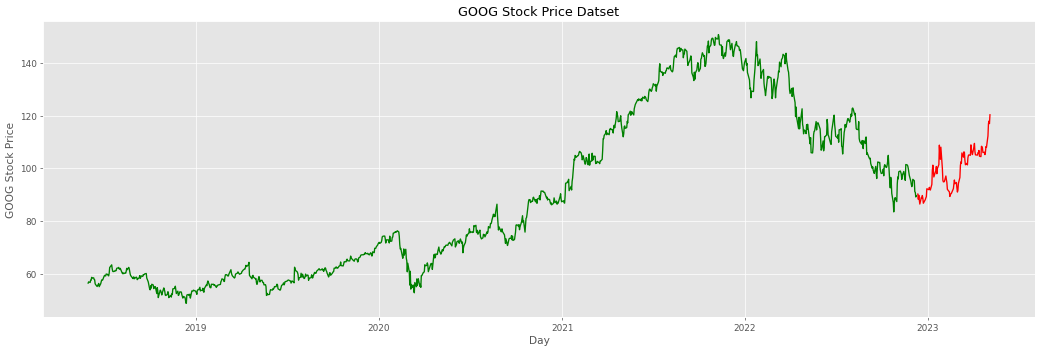

In [12]:
x_train, y_train = train_df.iloc[:,:-1], train_df.iloc[:,-1:]
x_test, y_test = test_df.iloc[:,:-1], test_df.iloc[:,-1:]

plt.plot(y_train, color='green', label='Train')
plt.plot(y_test, color='red', label='Test')
plt.title('GOOG Stock Price Datset')
plt.xlabel('Day')
plt.ylabel('GOOG Stock Price')
plt.show()

Finally, we will transform the data from the training and test sets.

In [13]:
x_train = input_scaler.transform(x_train)
x_test = input_scaler.transform(x_test)
y_train = output_scaler.transform(y_train)

x_train = np.reshape(x_train, (
    x_train.shape[0],                 # Examples
    SEQUENCE_LEN,                     # Number of timesteps
    x_train.shape[1] // SEQUENCE_LEN  # Number of components each sequence element
))
x_test = np.reshape(x_test, (x_test.shape[0], SEQUENCE_LEN, x_test.shape[1] // SEQUENCE_LEN))

print(f'Dataset shape:      {df.shape}')
print(f'Training: X shape = {x_train.shape}; Y shape = {y_train.shape}')
print(f'Test:     X shape = {x_test.shape}; Y shape = {y_test.shape}')

Dataset shape:      (1242, 61)
Training: X shape = (1142, 10, 6); Y shape = (1142, 1)
Test:     X shape = (100, 10, 6); Y shape = (100, 1)


## Implementando y entrenando nuestro modelo

Crearemos un modelo recurrente que, a partir de los datos de entrada (los datos bursátiles de un día determinado) sea capaz de inferir el valor de cierre del valor siete días después. Para ello, utilizaremos una unidad neuronal recurrente simple `SimpleRNN`.

En concreto, la red que crearemos estará compuesta por dos capas de unidades recurrentes de 128 parámetros con una capa de abandono después de cada una de ellas, de la siguiente manera:

`Input`->`SimpleRNN`->`Dropout`->`SimpleRnn`->`Dropout`->`Output`.

Recuerda que cuando las unidades recurrentes se apilan unas sobre otras debemos utilizar el parámetro `return_sequences` para que se conecten a la secuencia completa, de lo contrario dará error.

In [25]:
model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(128, return_sequences=True, input_shape=x_train.shape[1:]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.SimpleRNN(128, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.SimpleRNN(128),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_9 (SimpleRNN)    (None, 10, 128)           17280     
                                                                 
 dropout_9 (Dropout)         (None, 10, 128)           0         
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 10, 128)           32896     
                                                                 
 dropout_10 (Dropout)        (None, 10, 128)           0         
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 128)               32896     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                

Ahora entrenaremos el modelo, a ver qué tal se comporta.

In [26]:
history = model.fit(x_train, y_train, epochs=100)

Epoch 1/100
36/36 [==============================] - 3s 11ms/step - loss: 0.4487 - root_mean_squared_error: 0.6698
Epoch 2/100
36/36 [==============================] - 0s 12ms/step - loss: 0.2026 - root_mean_squared_error: 0.4501
Epoch 3/100
36/36 [==============================] - 0s 12ms/step - loss: 0.1523 - root_mean_squared_error: 0.3902
Epoch 4/100
36/36 [==============================] - 1s 16ms/step - loss: 0.1036 - root_mean_squared_error: 0.3218
Epoch 5/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0712 - root_mean_squared_error: 0.2668
Epoch 6/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0591 - root_mean_squared_error: 0.2430
Epoch 7/100
36/36 [==============================] - 1s 21ms/step - loss: 0.0466 - root_mean_squared_error: 0.2158
Epoch 8/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0468 - root_mean_squared_error: 0.2162
Epoch 9/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0362

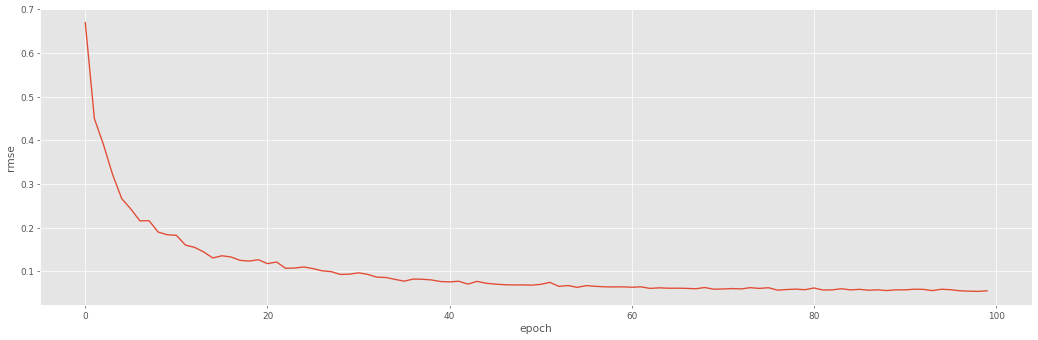

In [27]:
plt.plot(history.history['root_mean_squared_error'])
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.show()

No sólo no ha ido mal, ¡ha ido genial! Igual hasta nos hacemos ricos y todo...

## Evaluando el modelo

Finalmente vamos a predecir para el conjunto de test los valores de las acciones para luego compararlos con los valores de verdad.

Una nota: los datos del test vienen con un índice de fecha (es un `Series` de pandas) mientras que la predicción viene como un array de `NumPy`. Hay que conseguir que ambos índices coincidan.

4/4 [==============================] - 0s 5ms/step


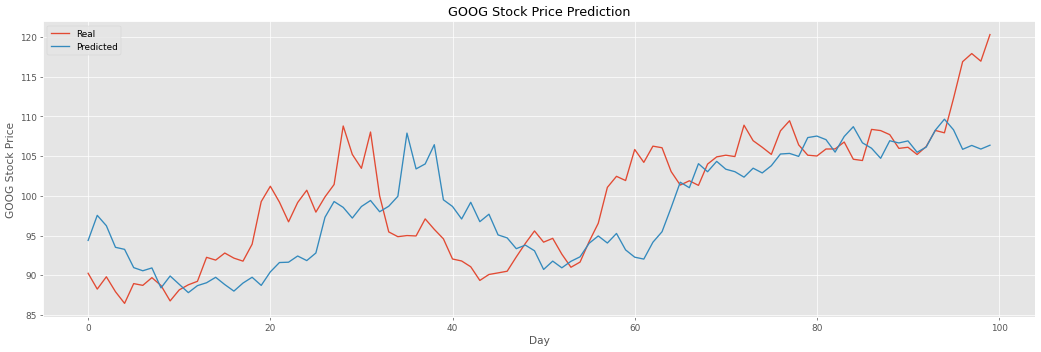

In [29]:
predicted = model.predict(x_test)
# Denormalize the output
predicted = output_scaler.inverse_transform(predicted)

plt.plot(y_test.to_numpy(), label = 'Real')
plt.plot(predicted, label = 'Predicted')
plt.title('GOOG Stock Price Prediction')
plt.xlabel('Day')
plt.ylabel('GOOG Stock Price')
plt.legend()
plt.show();

A la vista de los resultados, parece que está ocurriendo algo extraño... ¿Vamos a hacernos ricos o no? ¿Se te ocurre alguna explicación para esta curiosa predicción? ¿A alguien se le ocurre una alternativa?

## Conclusiones

Hemos visto cómo implementar redes neuronales recurrentes en un problema de series temporales puras. También hemos visto que no se comporta demasiado bien, pero no tiene por qué ser así (en este caso hay truco).

Las series temporales mantienen correlaciones entre elementos consecutivos, y esas relaciones son las que aprenden las redes. Cuanto mayor sea la correlación (absoluta) entre elementos, más probabilidades tendrá la red de adivinarla. Sin embargo, las sucesiones de elementos valorados aleatoriamente (que no tienen nada que ver entre sí) no son problemas que puedan resolverse con este tipo de redes. Ni siquiera son series temporales por definición.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Back to top](#top)

</div>